In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [4]:
g_sub = od+expand(config['lr']['subsample']['gene_summary'], species='human')[0]
t_sub = od+expand(config['lr']['subsample']['transcript_summary'], species='human')[0]

## 231220

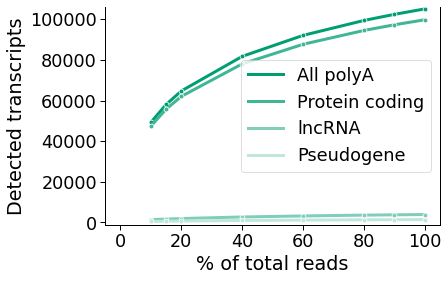

In [6]:
df = pd.read_csv(t_sub, sep='\t')

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='n_transcripts',
                  hue='gene_subset_2', palette=c_dict,
                  linewidth=3, marker='o')
_ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
           ylim=(-1000,106000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)

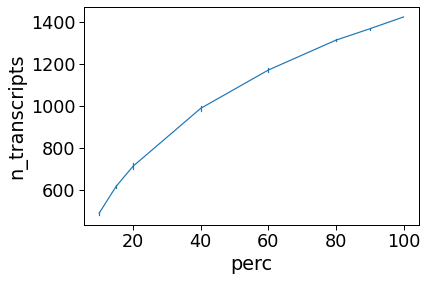

In [13]:
temp = df.loc[df.gene_subset=='pseudogene']
ax = sns.lineplot(temp, x='perc', y='n_transcripts', err_style='bars')

In [8]:
df.loc[(df.gene_subset=='polya')&(df.perc==10)]

,n_transcripts,depth,rep,gene_subset,gene_subset_2,perc
0,49287,0.1,0,polya,All polyA,10.0
4,49151,0.1,1,polya,All polyA,10.0
8,49316,0.1,2,polya,All polyA,10.0
12,49283,0.1,3,polya,All polyA,10.0
16,49322,0.1,4,polya,All polyA,10.0
20,49337,0.1,5,polya,All polyA,10.0
24,49188,0.1,6,polya,All polyA,10.0
28,49279,0.1,7,polya,All polyA,10.0
32,49414,0.1,8,polya,All polyA,10.0
36,49254,0.1,9,polya,All polyA,10.0


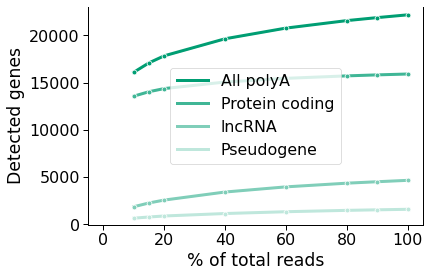

In [55]:
df = pd.read_csv(g_sub, sep='\t')

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
ax = sns.lineplot(df, x='perc', y='n_genes',
                  hue='gene_subset_2', palette=c_dict,
                  linewidth=3, marker='o')
_ = ax.set(xlabel='% of total reads', ylabel='Detected genes',
           ylim=(-10,23000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)

## some code to start running subsampling analysis

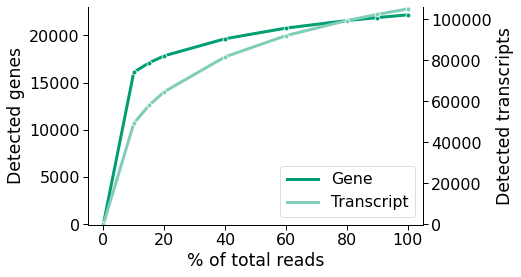

In [33]:
# g_df = pd.read_csv('test_gene_summary.tsv', sep='\t')
# t_df = pd.read_csv('test_transcript_summary.tsv', sep='\t')

g_df = pd.read_csv(g_sub, sep='\t')
t_df = pd.read_csv(t_sub, sep='\t')

df = g_df.merge(t_df, how='left', on=['depth', 'rep'])
temp = pd.DataFrame()
temp['n_genes'] = [0]
temp['n_transcripts'] = 0
temp['depth'] = 0
df = pd.concat([df, temp], axis=0)

df['perc'] = df.depth*100
df['dummy_x'] = -0
df['dummy_y'] = -10
df['dummy_hue'] = ['Transcript' if i != 0 else 'Gene' for i in range(len(df.index))]

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
cats = ['Gene', 'Transcript']
c_dict, order = get_shade_colors(c, cats)

sns.set_context('paper', font_scale=1.8)
ax = sns.lineplot(data=df, x='perc', y='n_genes',
             marker='o', linewidth=3, c=c_dict['Gene'])
ax2 = plt.twinx()
sns.lineplot(data=df, x='perc', y='n_transcripts',
             marker='o', linewidth=3, ax=ax2, c=c_dict['Transcript'])
sns.lineplot(data=df, x='dummy_x', y='dummy_y',
             hue='dummy_hue', palette=c_dict)
_ = ax.set(xlabel='% of total reads', ylabel='Detected genes',
           ylim=(-10,23000), xlim=(-5,105))
_ = ax2.set(ylabel='Detected transcripts',
            ylim=(-10,106000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend_.set_title(None)

# get the legend object
leg = ax2.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)

In [34]:
df.head()

,file_x,depth,rep,n_genes,file_y,n_transcripts,perc,dummy_x,dummy_y,dummy_hue
0,data/human/lr/subsample/unfilt_talon_abundance...,0.1,0.0,16109,data/human/lr/subsample/cerberus_filtered_abun...,49287,10.0,0,-10,Gene
1,data/human/lr/subsample/unfilt_talon_abundance...,0.1,1.0,16065,data/human/lr/subsample/cerberus_filtered_abun...,49151,10.0,0,-10,Transcript
2,data/human/lr/subsample/unfilt_talon_abundance...,0.1,2.0,16087,data/human/lr/subsample/cerberus_filtered_abun...,49316,10.0,0,-10,Transcript
3,data/human/lr/subsample/unfilt_talon_abundance...,0.1,3.0,16117,data/human/lr/subsample/cerberus_filtered_abun...,49283,10.0,0,-10,Transcript
4,data/human/lr/subsample/unfilt_talon_abundance...,0.1,4.0,16112,data/human/lr/subsample/cerberus_filtered_abun...,49322,10.0,0,-10,Transcript


In [21]:
df['dummy_data_x'] = -1
df['dummy_data_y'] = -1
df['dummy_hue'] = ['Transcript' if i != 0 else 'Gene' for i in range(len(df.index))]
df.head()

,file_x,depth,n_genes,file_y,n_transcripts,perc,dummy,dummy_data_x,dummy_data_y,dummy_hue
0,data/human/lr/subsample/unfilt_talon_abundance...,0.10,16032,data/human/lr/subsample/cerberus_filtered_abun...,49323,10.0,Gene,-1,-1,Gene
1,data/human/lr/subsample/unfilt_talon_abundance...,0.15,17044,data/human/lr/subsample/cerberus_filtered_abun...,58123,15.0,Transcript,-1,-1,Transcript
2,data/human/lr/subsample/unfilt_talon_abundance...,0.20,17861,data/human/lr/subsample/cerberus_filtered_abun...,64890,20.0,Transcript,-1,-1,Transcript
3,data/human/lr/subsample/unfilt_talon_abundance...,0.40,19700,data/human/lr/subsample/cerberus_filtered_abun...,81782,40.0,Transcript,-1,-1,Transcript
4,data/human/lr/subsample/unfilt_talon_abundance...,0.60,20767,data/human/lr/subsample/cerberus_filtered_abun...,91917,60.0,Transcript,-1,-1,Transcript


## also dev for transcript (filtered) level

In [28]:
sample_depth = .5

In [4]:
df = pd.read_csv(filt_ab, sep='\t')

In [6]:
# limit to just wtc11 
wtc11_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
df = df[['annot_transcript_id']+wtc11_cols]
df.head()

,annot_transcript_id,wtc11_1_3,wtc11_1_2,wtc11_1_1
0,"ENSG00000000003[1,1,1]",6,0,8
1,"ENSG00000000003[1,1,5]",47,26,38
2,"ENSG00000000003[1,1,6]",0,2,1
3,"ENSG00000000003[1,1,7]",173,67,112
4,"ENSG00000000003[1,1,8]",72,51,47


In [7]:
df.set_index('annot_transcript_id').sum(axis=1).sum(axis=0)

4990973

In [11]:
df = pd.melt(df, id_vars='annot_transcript_id', var_name='dataset', value_name='counts')
df.head()

,annot_transcript_id,dataset,counts
0,"ENSG00000000003[1,1,1]",wtc11_1_3,6
1,"ENSG00000000003[1,1,5]",wtc11_1_3,47
2,"ENSG00000000003[1,1,6]",wtc11_1_3,0
3,"ENSG00000000003[1,1,7]",wtc11_1_3,173
4,"ENSG00000000003[1,1,8]",wtc11_1_3,72


In [21]:
reads = []
tids = []
datasets = []
for ind, entry in df.iterrows():
    counts = entry.counts
    
    tid = [entry.annot_transcript_id for i in range(counts)]
    dataset = [entry.dataset for i in range(counts)]
    
    tids += tid
    datasets += dataset

In [26]:
temp = pd.DataFrame()
temp['annot_transcript_id'] = tids
temp['dataset'] = datasets

In [27]:
len(temp.index)

4990973

In [29]:
# sample to target depth
sample_df = temp.sample(frac=sample_depth,
                      replace=False)

In [36]:
len(sample_df.index)
sample_df['read_name'] = sample_df.index

In [40]:
def read_annot_to_counts(df):
    """
    Convert a long-form (one row = one read)
    read_annot style dataframe to a counts matrix 
    """
    # compute transcript counts from the sampled df
    temp = df.copy(deep=True)
    temp = temp.groupby(['dataset', 'annot_transcript_id']).count().reset_index()
    temp.set_index('annot_transcript_id', inplace=True)
    temp = temp.pivot(columns='dataset', values='read_name') 
    temp.columns.name = ''
    temp.fillna(0, inplace=True)
    temp.reset_index(inplace=True)
    return temp

In [45]:
df = read_annot_to_counts(sample_df)
df.head()


,annot_transcript_id,wtc11_1_1,wtc11_1_2,wtc11_1_3
0,"ENSG00000000003[1,1,1]",2.0,0.0,3.0
1,"ENSG00000000003[1,1,5]",29.0,11.0,21.0
2,"ENSG00000000003[1,1,7]",53.0,41.0,98.0
3,"ENSG00000000003[1,1,8]",25.0,33.0,37.0
4,"ENSG00000000003[1,10,5]",3.0,0.0,1.0


In [46]:
def add_ab_metdata(df, 
                   ab):
    """
    Add in gene and transcript metadata from a talon-style 
    abundance matrix
    """
    # merge in the transcript / gene info from the abundance file
    ab_df = pd.read_csv(ab, sep='\t')
    non_dataset_columns = ['gene_ID', 'transcript_ID', 'annot_gene_id',
                       'annot_transcript_id', 'annot_gene_name',
                       'annot_transcript_name', 'n_exons', 'length',
                       'gene_novelty', 'transcript_novelty', 'ISM_subtype']
    ab_df = ab_df[non_dataset_columns]
    df = df.merge(ab_df, how='left', on='annot_transcript_id')
    return df

In [47]:
df = add_ab_metdata(df, filt_ab)


In [48]:
df.head()

,annot_transcript_id,wtc11_1_1,wtc11_1_2,wtc11_1_3,gene_ID,transcript_ID,annot_gene_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,ISM_subtype
0,"ENSG00000000003[1,1,1]",2.0,0.0,3.0,57105,202958,ENSG00000000003.14,TSPAN6,"TSPAN6[1,1,1]",8.0,2206.0,Known,Known,NaN
1,"ENSG00000000003[1,1,5]",29.0,11.0,21.0,57105,"202958,202958",ENSG00000000003.14,TSPAN6,"TSPAN6[1,1,5]",8.0,2206.0,Known,Known,NaN
2,"ENSG00000000003[1,1,7]",53.0,41.0,98.0,57105,202958,ENSG00000000003.14,TSPAN6,"TSPAN6[1,1,7]",8.0,2206.0,Known,Known,NaN
3,"ENSG00000000003[1,1,8]",25.0,33.0,37.0,57105,202958,ENSG00000000003.14,TSPAN6,"TSPAN6[1,1,8]",8.0,2206.0,Known,Known,NaN
4,"ENSG00000000003[1,10,5]",3.0,0.0,1.0,57105,490452,ENSG00000000003.14,TSPAN6,"TSPAN6[1,10,5]",7.0,3542.0,Known,NIC,NaN


In [32]:
# # compute transcript counts from the read annot
# temp = sample_df.copy(deep=True)
# temp = temp.groupby(['dataset', 'annot_transcript_id']).count().reset_index()
# temp.set_index('annot_transcript_id', inplace=True)
# temp = temp.pivot(columns='dataset', values='read_name') 
# temp.columns.name = ''
# temp.reset_index(inplace=True)

In [4]:
sample_depths = [5*10**5, 7.5*10**5, 10**6,
                 2*10**6, 3*10**6, 4*10**6, 5*10**6,
                 5*10**6, 6542794]
print(sample_depths)
depth = sample_depths[0]
depth
min_tpm = 1

[500000, 750000.0, 1000000, 2000000, 3000000, 4000000, 5000000, 5000000, 6542794]


In [14]:
# read in the gene id, transcript id, dataset, and the read name from the read annot
df = pd.read_csv(read_annot, sep='\t', 
                 usecols=[0,1,11,12])

In [17]:
# limit to just the wtc11 datasets
wtc11_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
df = df.loc[df.dataset.isin(wtc11_cols)]

In [18]:
len(df.index)

6542794

In [24]:
sample_df = df.sample(n=depth,
                      replace=False)
sample_df.head()

,read_name,dataset,annot_gene_id,annot_transcript_id
121410981,m54284U_201023_135811/131728109/ccs,wtc11_1_1,ENSG00000140632.16,ENST00000321919.13
177328831,m54284U_201123_202240/92800770/ccs,wtc11_1_3,ENSG00000117859.18,ENST00000531828.5
136845067,m54284U_201121_072510/105120006/ccs,wtc11_1_1,ENSG00000079246.15,ENST00000392132.6
143753985,m54284U_201122_135349/150406883/ccs,wtc11_1_2,ENSG00000059804.15,ENST00000075120.11
127317051,m54284U_201121_072510/40370379/ccs,wtc11_1_1,ENSG00000080824.18,ENST00000216281.12


In [34]:
# def compute_t_counts_from_read_annot(df):
temp = sample_df.copy(deep=True)
temp = temp.groupby(['dataset', 'annot_gene_id', 'annot_transcript_id']).count().reset_index()
temp.drop('annot_gene_id', axis=1, inplace=True)
temp.set_index('annot_transcript_id', inplace=True)

In [35]:
temp.head()

,dataset,read_name
annot_transcript_id,,
ENST00000373020.8,wtc11_1_1,16
TALONT000490488,wtc11_1_1,1
TALONT000490420,wtc11_1_1,1
ENST00000371588.9,wtc11_1_1,2
TALONT001142797,wtc11_1_1,6


In [37]:
temp = temp.pivot(columns='dataset', values='read_name')

In [40]:
temp.columns.name = ''
temp.reset_index(inplace=True)

In [41]:
temp.head()

,annot_transcript_id,wtc11_1_1,wtc11_1_2,wtc11_1_3
0,ENST00000000233.9,21.0,17.0,18.0
1,ENST00000000412.7,17.0,15.0,34.0
2,ENST00000000442.10,9.0,4.0,8.0
3,ENST00000001008.5,51.0,30.0,73.0
4,ENST00000002125.8,3.0,6.0,6.0


In [43]:
# todo -- merge in the new gene ids from the fusion-fixed files abundance files!
ab_df = pd.read_csv(ab, sep='\t')


In [46]:
non_dataset_columns = ['gene_ID', 'transcript_ID', 'annot_gene_id',
                       'annot_transcript_id', 'annot_gene_name',
                       'annot_transcript_name', 'n_exons', 'length',
                       'gene_novelty', 'transcript_novelty', 'ISM_subtype']
ab_df = ab_df[non_dataset_columns]
print(len(temp.index))
temp = temp.merge(ab_df, how='left', on='annot_transcript_id')
print(len(temp.index))     

108119
108119


In [47]:
temp.set_index(non_dataset_columns).sum(axis=1).sum(axis=0)

500000.0

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)
    
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

sample_depths = [5*10**5, 7.5*10**5, 10**6,
                 2*10**6, 3*10**6, 4*10**6, 5*10**6,
                 5*10**6, 6542794]
print(sample_depths)
depth = sample_depths[0]
depth
min_tpm = 1

[500000, 750000.0, 1000000, 2000000, 3000000, 4000000, 5000000, 5000000, 6542794]


In [2]:
# temp.to_csv('temp_subsample_wtc11.tsv', sep='\t', index=False)
temp = pd.read_csv('temp_subsample_wtc11.tsv', sep='\t')

In [3]:
df, inds = get_tpm_table(temp,
                    how='gene',
                    gene_subset='polya',
                    min_tpm=min_tpm)

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 20595
# genes >= 1 tpm: 20595
Applying gene type and novelty subset
Number of genes reported: 15380


In [ ]:
# merge w/ the non-dataset info from the abundance file

## 18/12/23 from abundance? (idk if this will work...)

In [4]:
ab = od+expand(config['lr']['talon']['ab'], species='human')[0]

In [5]:
df = pd.read_csv(ab, sep='\t')

In [6]:
len(df.index)

5395598

In [7]:
non_dataset_columns = ['gene_ID', 'transcript_ID', 'annot_gene_id',
                       'annot_transcript_id', 'annot_gene_name',
                       'annot_transcript_name', 'n_exons', 'length',
                       'gene_novelty', 'transcript_novelty', 'ISM_subtype']
df.set_index(non_dataset_columns, inplace=True)

In [10]:
# limit to just wtc11 
wtc11_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
df = df[wtc11_cols]

In [11]:
df.sum(axis=1).sum(axis=0)

6542794